<h1 style="text-align: center;">PANDAS - Manipulation et Visualisation des données</h1>

Pandas est une bibliothèque écrite pour le langage Python, spécialisée dans la manipulation et l'analyse des données. Elle a été créée en 2008 par **AQR Capital Management**  (société d'investissement spécialisée en recherche quantitative), et a été passée en license open source en 2009. Elle s'est imposée comme LA référence en matière de manipulation des données dans l'environnement python et a beaucoup contribué à son essor.

Les principaux atouts de pandas :
- Permet la création et la gestion efficace de *DataFrame* (càd structure de données complexes en deux dimensions);
- Permet la création et la gestion de *Panels* (représentation des données selon 3 dimensions);
- Permet la création et la gestion de *Panels4D* (représentation des données selon 4 dimensions, càd avec des index hiérarchiques);
- Permet de lire ou écrire des fichiers de données (Excel, CSV, Parquet, Pickles, etc);
- Permet de gérer des séries temporelles;
- Permet de découper, d'agréger des jeux de données;
- Permet la visualisation des données avec de nombreux types de graphiques.

>AQR = Applied Quantitative Research


Nous allons travailler sur des données financières (bilans et résultats financiers trimestriels) publiées à travers le temps par les entreprises du S&P 100 (l'univers à décembre 2022). 

*Lien vers la documentation :* [https://pandas.pydata.org/docs/reference/index.html]

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
<b>Objectifs :</b><br><br> 
- Connaissance du marché (métriques globales et sectorielles)<br>
- Selection d'entreprises affichant un bilan solide (chiffre d'affaires récurrent, dette faible, marge opérationnelle significative)<br><br>   
<b>A l'issue de ces travaux vous aurez acquis les compétences suivantes :</b><br><br>
- Accéder aux données d'un fichier<br>
- Effectuer des contrôles de cohérence sur les données<br>
- Manipuler et visualiser des données<br>
</p>

<b>Plan du notebook :</b><br><br>
1. <a href='#data_acquisition'>Acceder aux données</a><br>
2. <a href='#data_exploration'>Exploration aux données</a><br>
3. <a href='#data_augmentation'>Augmentation des données</a><br>
4. <a href='#data_analysis'>Analyse des données</a><br>
<a href='#annexe'>Annexe</a>

---
<a id='data_aacquisition'><h2 style="text-align: center;">Acceder aux données</h2></a>

Pandas facilite l'accès à différents types de fichiers (liste complète en annexe). Les plus connus sont les suivants :
- Pickles
- Excel
- Csv (flat file)
- Parquet
- Clipboard (le presse-papier)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt # module de graphique
import seaborn as sns # utile pour changer la couleur de fonds dans les tableaux et pour les graphiques
import numpy as np

**Extraction des données brutes depuis des fichiers Excel**

In [2]:
my_path = "C:\\Users\\Come5\\SynoCome\\AVerley\\PRIVATE\\NoteBook\\" # Définir votre chemin d'accès.
   
financials = pd.read_excel(my_path + "sp100_dec2022_financials.xlsx", header=0, index_col=0, parse_dates=True)
earnings = pd.read_excel(my_path + "sp100_dec2022_earnings.xlsx", header=0, index_col=0, parse_dates=True)
cashflows = pd.read_excel(my_path + "sp100_dec2022_cashflows.xlsx", header=0, index_col=0, parse_dates=True)
raw_prices = pd.read_excel(my_path + "sp100_dec2022_prices.xlsx", header=0, index_col=0, parse_dates=True)

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
Etant donné que les jeux de données sont conséquents, ce processus peut prendre un peu de temps !</p>

> **Remarque :**
> Il existe de nombreux paramètres permettant d'améliorer l'extraction d'informations lors de la lecture d'un fichier Excel ou Csv. Certains d'entre eux sont clés pour le succès de l'analyse surtout si vous travaillez sur des séries temporelles avec des dates et des nombres formatés à l'Européenne (e.g décimale en virgule et dates commençant par la jour).

Afin de calculer certains ratios financiers, nous allons fusionner nos jeux de données (financials, earnings et prices). Pour se faire, nous devons effectuer les jointures sur deux critères (date et ticker) qui sont communs à tous les jeux de données. Il existe plusieurs méthodes pour effectuer des jointures de données (concat, merge, merge_asof ou join) avec pour chacune des avantages et des inconvénients.

In [6]:
# Pour faciliter la fusion des prix avec les autres jeux de données, il faut d'abord revoir le format de cette variable.
prices = raw_prices.stack().rename_axis(['Date','Ticker']).to_frame('Prices').reset_index(1)

In [7]:
merge1 = pd.merge(financials, earnings, how='left', on=["Date","Ticker"])
merge2 = pd.merge(merge1, cashflows, how='left', on=["Date","Ticker"], suffixes=(None, "_y"))

> On observe une petite différence lors de la création de la variable merge2 !
>
> Nous avons rajouté l'attribut "suffixes" qui doit être renseigné à l'aide d'un tuple car il savère que la variable "netIncome" existe dans deux jeux de données (financials et cashflows), ce qui créer un conflit lors de la jointure. La définition des suffixes permet de le cas présent de renommer les colonnes pour que ce conflit n'est pas lieu.

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black;">    
Dans le cas présent, je définis un seul suffixe, pour le deuxième jeu de données (cashflows)

<br>Pour s'assurer que j'ai bien mes deux colonnes (netIncome et netIncome_y), je peux effectuer les tests suivants :</br>
- "netIncome" in merge2.columns
- "netIncome_y" in merge2.columns
</p>

In [6]:
"netIncome_y" in merge2.columns

True

Nous allons nous arrêter ici un instant, et comparer deux méthodes de "fusion" de données :
- complete1 : nous effectuons une jointure avec la méthode merge;
- complete2 : nous effectuons une jointure avec la méthode merge_asof

>Il n'y a pas une méthode supérieure à l'autre, seule les besoins/contraintes de l'analyse vont en favoriser l'une par rapport à l'autre !

In [8]:
complete1 = pd.merge(merge2, prices, how='left', on=['Date','Ticker'])

tol = pd.Timedelta('5 day')
complete2 = pd.merge_asof(merge2.sort_values('Date'), prices, on='Date', by='Ticker', tolerance=pd.Timedelta('5 day'))

Mettons en lumière la différence entre les deux méthodes en comparant une même donnée, sur les deux jeux :

In [9]:
complete1[(complete1.Ticker == "SO.US") & (complete1.index == "2018-09-30")]

,filing_date_income,currency_symbol_income,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,sellingAndMarketingExpenses,grossProfit,...,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,changeInWorkingCapital,otherNonCashItems,freeCashFlow,Prices
Date,,,,,,,,,,,,,,,,,,,,,
2018-09-30,2018-11-07,USD,0.0,0.0,1.845000e+09,54000000.0,1.168000e+09,319000000.0,NaN,2.964000e+09,...,-315000000.0,1.965000e+09,-57000000.0,474000000.0,NaN,-126000000.0,536000000.0,-352000000.0,361000000.0,NaN


Dans le résultat ci-dessus, nous pouvons observer que dans la dernière colonne "Prices" nous avons une valeur manquante. C'est souvent le cas lorsqu'on essaie de réconcilier des données de marchés avec des données de bilan. En effet, les données de bilan sont publiées pour une date (e.g la fin d'un exercice comptable), même si ce jour n'est pas ouvré. Elle concerne une période (une année, un semestre, un trimestre, etc), et donc le choix de la date n'a pas d'importance.

Cependant, pour construire certains ratios financiers, nous devons utiliser des données de marchés !

In [9]:
complete2[(complete2.Ticker == "SO.US") & (complete2.Date == "2018-09-30")]

,filing_date_income,Date,currency_symbol_income,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,sellingAndMarketingExpenses,...,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,changeInWorkingCapital,otherNonCashItems,freeCashFlow,Prices
11024,2018-11-07,2018-09-30,USD,0.0,0.0,1.845000e+09,54000000.0,1.168000e+09,319000000.0,NaN,...,-315000000.0,1.965000e+09,-57000000.0,474000000.0,NaN,-126000000.0,536000000.0,-352000000.0,361000000.0,36.4258


Avec cette deuxième méthode (mais il en existe d'autres), nous avons pu faire en sorte que lorsque la donnée est manquante à une date, elle puisse être imputée par la plus proche valeur connue (dans un interval de 5 jours). En effet, si votre date de publication est un dimanche, il est normal que vous n'ayez pas de cours de bourse. Dans ce cas là, il paraît logique d'utiliser le dernier cours connu, c'est à dire le vendredi d'avant (s'il est ouvré).

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
<b>c'est avec ces données que nous allons travailler !</b>
</p>

D'ailleurs, pandas nous permet de savoir facilement quel jour est le 30/09/2018 :

In [10]:
pd.to_datetime("2018-09-30").weekday() # weekday() = 6 = Dimanche (et 0 = Lundi)

6

Et pour s'assurer que le prix est correct, il suffit d'extraire celui du vendredi d'avant (c'est à dire le 28/09/2018) :

In [11]:
raw_prices[raw_prices.index == "2018-09-28"]["SO.US"] # C'est bien le prix que nous retrouvons dans le résultat de notre merge_asof

Date
2018-09-28    36.4258
Name: SO.US, dtype: float64

<a id='data_exploration'><h2 style="text-align: center;">Exploration des données</h2></a>

Dans un processus classique d'analyse des données, cette étape est effectuée juste après l'import des données, mais pour gagner du temps (comme je connais déjà les données), je vous montre ces méthodes sur le jeu complet.

In [12]:
print("******* Exploration & Cohérence *******")
print("\n Dimensions de notre jeu de données : \n")
print(complete2.shape)
print("\n Informations globales le jeu de données : \n")
complete2.info()
print("\n Les types de mes colonnes : \n")
print(complete2.dtypes)
print("\n Les types de mes colonnes : \n")
complete2.describe()

******* Exploration & Cohérence *******

 Dimensions de notre jeu de données : 

(12709, 134)

 Informations globales le jeu de données : 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12709 entries, 0 to 12708
Columns: 134 entries, filing_date_income to Prices
dtypes: datetime64[ns](5), float64(122), object(7)
memory usage: 13.1+ MB

 Les types de mes colonnes : 

filing_date_income               datetime64[ns]
Date                             datetime64[ns]
currency_symbol_income                   object
researchDevelopment                     float64
effectOfAccountingCharges               float64
                                      ...      
cashAndCashEquivalentsChanges           float64
changeInWorkingCapital                  float64
otherNonCashItems                       float64
freeCashFlow                            float64
Prices                                  float64
Length: 134, dtype: object

 Les types de mes colonnes : 



,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,sellingAndMarketingExpenses,grossProfit,reconciledDepreciation,ebit,...,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,changeInWorkingCapital,otherNonCashItems,freeCashFlow,Prices
count,8.128000e+03,6819.0,1.152300e+04,7.856000e+03,1.189300e+04,1.042500e+04,2.410000e+03,1.115800e+04,1.098000e+03,1.145900e+04,...,5.035000e+03,1.161300e+04,3.154000e+03,3.934000e+03,2.222000e+03,4.277000e+03,1.129600e+04,1.114800e+04,1.144700e+04,12211.000000
mean,4.947546e+08,0.0,1.599693e+09,1.050921e+08,1.139266e+09,2.173228e+09,1.474291e+09,4.986797e+09,1.275662e+09,1.948934e+09,...,1.060504e+08,7.606085e+08,-1.830737e+08,4.130248e+08,-2.688512e+07,2.250063e+08,-9.651885e+07,1.479911e+08,1.207841e+09,55.994376
std,1.168015e+09,0.0,3.320793e+09,7.699393e+09,2.722874e+09,4.771272e+09,7.808562e+09,7.409106e+09,1.687510e+09,8.445113e+09,...,5.633745e+09,1.627163e+09,2.761223e+09,9.257283e+09,2.661249e+08,7.821763e+09,2.059820e+10,1.887830e+10,5.637291e+09,126.853946
min,0.000000e+00,0.0,-6.304900e+10,-2.146730e+11,-6.165900e+10,0.000000e+00,4.220000e+05,-7.261300e+10,5.000000e+06,-5.609300e+11,...,-2.190460e+11,0.000000e+00,-4.971900e+10,-2.262320e+11,-4.541000e+09,-1.403040e+11,-7.696710e+11,-7.727100e+11,-2.020140e+11,0.042200
25%,0.000000e+00,0.0,2.835500e+08,0.000000e+00,1.650000e+08,3.429000e+08,1.832845e+08,9.868000e+08,3.629250e+08,3.110000e+08,...,-1.029350e+07,9.391700e+07,-3.120000e+08,-2.190000e+08,-4.400000e+07,-7.470000e+08,-3.332750e+08,-4.900000e+07,4.654550e+07,8.196800
50%,1.085000e+07,0.0,8.810000e+08,0.000000e+00,5.900000e+08,1.053200e+09,4.600000e+08,2.562050e+09,6.845000e+08,1.000000e+09,...,1.030000e+08,2.730000e+08,-5.254600e+07,1.053950e+07,-3.000000e+06,4.280000e+07,-8.286500e+06,2.300000e+07,5.340000e+08,24.316700
75%,4.744895e+08,0.0,1.993000e+09,1.900000e+07,1.415000e+09,2.622000e+09,1.587750e+09,5.897750e+09,1.679750e+09,2.312000e+09,...,4.060235e+08,6.950000e+08,1.010000e+08,3.965000e+08,2.500000e+07,9.739040e+08,2.550000e+08,2.310250e+08,1.711600e+09,54.939100
max,1.948500e+10,0.0,1.266030e+11,3.932660e+11,1.271400e+11,2.755859e+11,2.759420e+11,1.437960e+11,3.029100e+10,5.812770e+11,...,1.421470e+11,4.927700e+10,4.969700e+10,2.616670e+11,3.049000e+09,1.904300e+11,7.728040e+11,7.683360e+11,1.959040e+11,2399.230000


Quelles sont les informations que nous donnent ces fonctions ?

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
<b>financials.info()</b><br><br> 
Cette méthode nous renvoie des informations globales sur le jeu de données :<br>
- son type, càd un dataframe dans le cas présent --> pandas.core.frame.DataFrame<br>
- on sait que c'est un jeu de données indexé par le temps et le nombre de lignes --> Int64Index: 12709 entries<br>
- on sait qu'il y a 134 colonnes --> Columns: 134 entries<br>
- on sait qu'il est composé de 3 types de données --> dtypes: datetime64[ns](5), float64(122), object(7)<br>
- on peut connaître le nombre de valeurs non nulles<br>
- l'espace mémoire qu'il consomme --> memory usage: 13.1+ MB<br>
</p>

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
<b>financials.dtypes</b><br><br> 
Cette méthode nous renvoie des informations sur les types de nos colonnes. Ici, il est important de s'assurer de la cohérence des types, pour que des variables numériques soient bien traitées comme telles. Des nombres à décimales à virgule pourraient par exemple être traités comme des chaînes de caractères.<br>
Si des variables n'ont pas le bon type, il est possible de les modifier après importation, sinon il faut revoir les paramètres d'extraction.<br>
Note : L'information du type peut-être retrouvée dans la méthode info() !<br>
</p>

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
<b>financials.describe()</b><br><br> 
Cette méthode nous renvoie des informations de statistiques descriptives sur le jeu de données (lorsque c'est possible) :<br>
- Nombre<br>
- Moyenne<br>
- Ecart-type<br>
- Minimum & Maximum<br>
- Intervalles interquartiles
</p>

<a id='data_augmentation'><h2 style="text-align: center;">Augmentation des données</h2></a>

Nous avons maintenant une vue d'ensemble de nos données, nous connaissons nos colonnes, leurs types, le nombre de valeurs manquantes et bien d'autres informations. Mais cette donnée est brute et manque de profondeur, c'est pourquoi nous allons essayer de l'augmenter, c'est à dire lui permettre de nous donner des informations supplémentaires.

Pour commencer, nous allons rajouter des éléments de dates qui vont faciliter notre analyse pour la suite.

In [11]:
# Nous allons rajouter ici des éléments de date qui pourraient faciliter nos analyses plus tard
complete2["year"] = complete2["Date"].dt.year
complete2["quarter"] = complete2["Date"].dt.quarter
complete2["month"] = complete2["Date"].dt.month

>Cette manipulation (extraction des années, trimestres et mois) est facilitée par le fait qu'à l'import, nous avons fait en sorte que nos dates soient bien interprétées comme telles (pour rappel : parse_dates=True). Dans l'exploration, elles apparaîssent avec le type datetime64[ns] et sont format est le suivant :
>
>Timestamp('1985-07-31 00:00:00')

Ensuite, nous allons augmenter notre jeu de données d'un certain nombre de ratios financiers qui vont nous aider dans nos travaux de stock picking :

| Ratio | Type |Logique |
|:-------|:------:|:------|
| PE ratio | Valorisation|Ratio permettant de mesurer combien de fois se paie les bénéfices d'une entreprise|
| PB ratio | Valorisation|Ratio permettant de comparer la valeurs de marché d'une entreprise à celle de ses actifs retraités de la dette|
| EV/EBITDA| Valorisation |Ratio permettant de comparer la valeur d'une entreprise à son ebitda|
|Free Cash Flow Yield | Profitabilité / Rendement pour l'actionnaire | C'est le montant du résultat net de l'entreprise qui est distribuable à l'actionnaire |
|Dividend Yield | Rendement de l'actionnaire | Rendement offert à l'actionnaire pour prendre le risque d'investir dans une entreprise|
| Return On Equity| Profitabilité | Indicateur permettant de mesurer la création de richesse de l'entreprise pour l'actionnaire |
| Return On Assets| Profitabilité | Indicateur permettant de mesurer le niveau de création de richesse des actifs de l'entreprise|
| Gross Margin | Profitabilité | Indicateur de marge brute qui permet de mesurer dans quelle mesure une entreprise gagne de l'argent une fois que l'on prend en compte les coûts de production|
| Debt to Equity | Levier | Permet de comparer la dette d'une entreprise à sa valeur de marché|
| Capex per Share | Coûts |Permet de mesurer le coût récurrent moyen par actions|

>Les formules de calculs de ces ratios financiers sont retrouvables plus bas dans les annexes.

Bien sûr, il est possible de calculer de nombreux autres ratios, mais ce n'est pas le but de l'exercice. Sur la base de ce que nous aurons déjà, nous essaierons de sélectionner quelques actions pour construire un portefeuille.

>**Remarque :** les données que nous manipulons sont des données trimestrielles, que nous allons comparer à des prix de marchés qui sont eux comparables à une base annuelles, ce qui introduit un biais dans l'analyse. Pour que les données soient comparables, nous pouvons :
> - multiplier nos données de bilan par 4 (ou diviser le cours de bourse par 4). Cela introduit un biais non négligeable dans l'analyse dès que l'on regarde le résultat en valeur absolue, puisque la multiplication par 4 (ou division du prix) introduit l'hypothèse que les résultats trimestriels sont constants sur l'année. Or, certains métiers très cycliques vont avoir des piques de résultats sur certains trimestres à cause de la saisonnalité de leur activité, et des trous dans d'autres. En revanche, ce biais est moins prégnant si l'on compare les sociétés entre elles, puisqu'elles ont toute subies le même traitement.
> - utiliser la méthode groupby avec somme, mais cette opération fait disparaître les colonnes de données catégoriques et introduit également des biais pour les entreprises dont les résultats ne sont pas complets (comme pour l'exercice clôt au 31/12/2022 où les entreprises commencent à peine la publication). Cela nous obligerait à effectuer l'analyse uniquement sur les exercices annuels complet, et ils nous faudrait attendre encore quelques semaines pour avoir l'intégralité des publications de 2022.

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
Nous allons travailler avec la première méthode pour la suite de l'exercice.
</p>

In [12]:
complete2["pe_ratio"] = complete2["Prices"] / (complete2["epsActual"] * 4.)

complete2["book_value"] = complete2["totalAssets"] - complete2["totalLiab"]

complete2["pb_ratio"] = complete2["Prices"] / ((complete2["book_value"] * 4) / complete2["commonStockSharesOutstanding"])

complete2["enterprise_value"] = (complete2["commonStockSharesOutstanding"] * complete2["Prices"]) \
    + complete2["longTermDebt"] + complete2["shortTermDebt"] - complete2["cashAndEquivalents"]

complete2["ev_ebitda"] = complete2["enterprise_value"] / (complete2["ebitda"] * 4)

complete2["fcfy"] = (complete2["freeCashFlow"] * 4) / (complete2["Prices"] * complete2["commonStockSharesOutstanding"])

complete2["div_yield"] = ((complete2["dividendsPaid"] * 4) / complete2["commonStockSharesOutstanding"]) / complete2["Prices"]

complete2["roe"] = complete2["netIncome"] / complete2["totalStockholderEquity"]

complete2["roa"] = complete2["netIncome"] / complete2["totalAssets"]

complete2["gross_margin"] = complete2["grossProfit"] / complete2["totalRevenue"]

complete2["debt_to_equity"] = (complete2["longTermDebt"] + complete2["shortTermDebt"]) / complete2["totalStockholderEquity"]

complete2["capex_per_share"] = complete2["capitalExpenditures"] / complete2["commonStockSharesOutstanding"]

<a id='data_analysis'><h2 style="text-align: center;">Analyse des données</h2></a>

Nous allons porter notre attention sur quelques métriques clées :
- pe_ratio
- pb_ratio 
- fcfy
- roe
- gross_margin 
- capex_per_share

Avec une vision spot (dernier quarter) et une vision temporelle.

In [27]:
# Setup des couleurs pour la coloration des dataframes
cm = sns.light_palette("green", as_cmap=True)

# Combien j'ai de publications à chaque date ?
# ["ebitda","netIncome","operatingIncome","totalRevenue","cash","netDebt"]
my_ratios = ["pe_ratio","pb_ratio","fcfy","roe","gross_margin","capex_per_share"]
df = complete2.groupby(["Date"]).count()[my_ratios].tail(20).copy() # je liste uniqement les 2O derniers
df.style.background_gradient(cmap=cm).set_precision(2)

C:\Users\Come5\AppData\Local\Temp\ipykernel_15196\981350744.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.style.background_gradient(cmap=cm).set_precision(2)


,pe_ratio,pb_ratio,fcfy,roe,gross_margin,capex_per_share
Date,,,,,,
2021-04-30 00:00:00,9,9,9,9,9,9
2021-05-31 00:00:00,7,7,7,7,7,7
2021-06-30 00:00:00,84,84,84,84,84,84
2021-07-31 00:00:00,9,9,9,9,9,9
2021-08-31 00:00:00,7,7,7,7,7,7
2021-09-30 00:00:00,84,84,84,84,84,84
2021-10-31 00:00:00,9,9,9,9,9,9
2021-11-30 00:00:00,7,7,7,7,7,7
2021-12-31 00:00:00,84,84,84,84,84,84


**Remarque :**

Sur 100 sociétés dans l'indice, on observe que 84 d'entres elles ont un exercice fiscal "classique" arrêté sur les fins de trimestres. Les autres (les 7 + 9), ont des exercices fiscaux trimestriels décalés (clôturant en janvier ou février au lieu de décembre).

Pour être sûr d'avoir toutes les publications à chaque trimestre, je vais regrouper et agréger les données par trimestre.

In [28]:
complete2.groupby(['year','quarter']).count()[my_ratios]

pe_ratio  pb_ratio  fcfy  roe  gross_margin  capex_per_share
year quarter                                                              
1985 3               0         2     0    0             0                0
     4               0        11     0    2             0                0
1986 1               0         1     0    0             0                0
     2               0         2     0    0             0                0
     3               0         3     0    0             0                0
...                ...       ...   ...  ...           ...              ...
2021 4             100       100   100  100           100              100
2022 1             100       100   100  100           100              100
     2             100       100   100  100           100              100
     3             100       100   100  100            99              100
     4              15        15    15   15            15               15

[150 rows x 6 columns]

Les données peuvent être représentées de différentes manières :

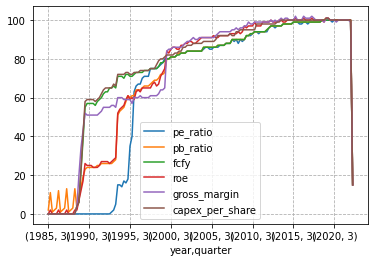

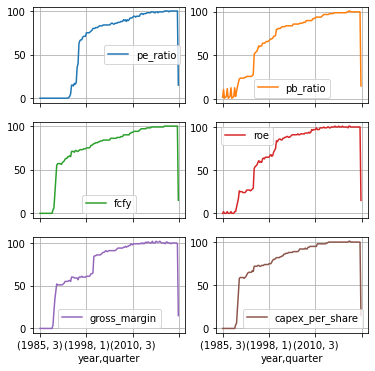

In [29]:
quarters = complete2.groupby(["year","quarter"]).count().copy()
quarters[my_ratios].plot()
plt.grid(linestyle="--")

quarters[my_ratios].plot(subplots=True, layout=(3, 2), figsize=(6, 6), grid=True);

>**Remarques**
>- Hausse du nombre des publications dans le temps : on travaille sur un univers de titres à un instant t, qui n'est pas le même que par le passé puisque les indices changent, de plus certaines des sociétés ont un historique de publication plus faible que les autres (notamment dans les secteurs modernes).
>- La baisse en fin de série vient du fait que beaucoup d'entreprises n'ont pas encore publiées leurs résultats pour la clôture fiscale de décembre 2022.

### 1. Vision Spot

Dans l'exemple ci-dessous, nous allons afficher quelques statistiques descriptives concernant l'univers complet, pour un trimestre donné (3ème trimestre de l'année 2022).

In [132]:
# FORMATAGE DES RESULTATS
# Comme nous allons travailler avec des données exprimées en milliards, 
# il est possible de formater les résultats afin qu'ils soient plus compréhensibles
pd.set_option('display.float_format', lambda x: '%.2f M$' % x)
#pd.reset_option('all')

# Sur l'ensemble des valeurs du S&P100, sur le dernier trimestre complet (septembre 2022)
complete2[(complete2["year"] == 2022) & (complete2["quarter"] == 3)].agg({
    'totalRevenue':['min','mean','median','max','std'],
    'netIncome':['min','mean','median','max','std'],
    'cash':['min','mean','median','max','std'],
    'netDebt':['min','mean','median','max','std']})/1000000

,totalRevenue,netIncome,cash,netDebt
min,1315.79 M$,-4598.00 M$,3.00 M$,-92954.00 M$
mean,22646.43 M$,2740.94 M$,22031.53 M$,36514.52 M$
median,13305.50 M$,1681.00 M$,6869.00 M$,20598.00 M$
max,152859.00 M$,20721.00 M$,648821.00 M$,335336.00 M$
std,26851.14 M$,4116.65 M$,73226.15 M$,56070.18 M$


Quelles sont les 5 premières entreprises de l'indice en termes de résultat net sur les 3 premiers trimestre de l'année ?

In [148]:
complete2[(complete2.year == 2022) & (complete2.quarter < 4)]\
.groupby(["year","Ticker","Name"])\
.sum()["netIncome"]\
.sort_values(ascending=False)\
.head(6)/1000000

year  Ticker    Name                 
2022  AAPL.US   Apple Inc               65173.00 M$
      MSFT.US   Microsoft Corporation   51024.00 M$
      GOOG.US   Alphabet Inc Class C    46348.00 M$
      GOOGL.US  Alphabet Inc Class A    46348.00 M$
      XOM.US    Exxon Mobil Corp        42990.00 M$
      CVX.US    Chevron Corp            29112.00 M$
Name: netIncome, dtype: float64

>Ce que je voulais montrer juste au-dessus, c'est qu'il est possible de formater les sorties de tableau de manière à les rendre plus lisibles. Dans le cas présent, j'exprime les données en millions de dollars.

In [159]:
pd.reset_option('all')
complete2[(complete2["year"] == 2022) & (complete2["quarter"] == 3)].agg({
    'totalRevenue':['min','mean','median','max','std'],
    'netIncome':['min','mean','median','max','std'],
    'cash':['min','mean','median','max','std'],
    'netDebt':['min','mean','median','max','std']})

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



C:\Users\Come5\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\_config\config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
C:\Users\Come5\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\_config\config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


,totalRevenue,netIncome,cash,netDebt
min,1.315786e+09,-4.598000e+09,3.000000e+06,-9.295400e+10
mean,2.264643e+10,2.740944e+09,2.203153e+10,3.651452e+10
median,1.330550e+10,1.681000e+09,6.869000e+09,2.059800e+10
max,1.528590e+11,2.072100e+10,6.488210e+11,3.353360e+11
std,2.685114e+10,4.116648e+09,7.322615e+10,5.607018e+10


**Regardons nos ratios financiers à l'échelle des secteurs**

In [56]:
pe_by_sector = complete2[(complete2["year"] == 2022) & (complete2["quarter"] == 3)].groupby("Sector").agg({
    'pe_ratio':['min','mean','median','max','std']})
pe_by_sector

pe_ratio                                             
                              min       mean     median         max        std
Sector                                                                        
Basic Materials          9.756171  15.571482  15.292744   21.665532   5.959571
Communication Services   5.462390  27.758399  19.835012   83.856250  28.978239
Consumer Cyclical        3.557644  28.520240  18.058074  100.892857  30.637807
Consumer Defensive       7.727090  26.473531  19.961783  102.754231  25.973144
Energy                   4.864663   6.103429   6.410396    7.035229   1.117368
Financial Services       5.457286  14.267323  13.308010   26.438619   6.476582
Healthcare               6.093834  16.325960  12.950528   40.718510   8.938982
Industrials             -4.898058  14.052638  14.303133   34.474500   9.148326
Real Estate             13.392879  21.389544  21.389544   29.386208  11.308992
Technology               8.966789  25.411809  17.839684   88.985098  20.889659
Utilities               12.378600  15.273887  12.885856   22.945235   5.119950

In [57]:
pb_by_sector = complete2[(complete2["year"] == 2022) & (complete2["quarter"] == 3)].groupby("Sector").agg({
    'pb_ratio':['min','mean','median','max','std']})
pb_by_sector

pb_ratio                                             
                             min       mean    median         max         std
Sector                                                                       
Basic Materials         0.246051   0.509298  0.417444    0.864400    0.319244
Communication Services  0.202919   0.752518  0.668282    1.291264    0.407298
Consumer Cyclical      -6.460230  32.372920  1.193695  321.330148  101.597276
Consumer Defensive     -4.295904   1.736301  1.754001   13.893340    4.758987
Energy                  0.433167   0.519757  0.471082    0.655023    0.118668
Financial Services      0.066245   1.118117  0.308954   10.645371    2.534236
Healthcare              0.254813   1.956044  1.146832    8.242243    2.377667
Industrials            -1.023018   1.106540  1.099464    2.561936    0.996902
Real Estate             1.799033   1.901721  1.901721    2.004410    0.145223
Technology             -9.263311   1.883285  2.014653   10.971949    4.308568
Utilities               0.339715   0.509353  0.436842    0.824013    0.220849

In [58]:
de_by_sector = complete2[(complete2["year"] == 2022) & (complete2["quarter"] == 3)].groupby("Sector").agg({
    'debt_to_equity':['min','mean','median','max','std']})
de_by_sector

debt_to_equity                                   \
                                  min       mean    median         max   
Sector                                                                   
Basic Materials              0.407622   0.547368  0.475692    0.758790   
Communication Services       0.066783   1.846477  0.953578   10.948701   
Consumer Cyclical           -5.409689  19.353368  0.622867  176.991561   
Consumer Defensive          -6.212429   1.109654  0.744417   13.260450   
Energy                       0.162982   0.250891  0.244105    0.345586   
Financial Services           0.162307   1.429185  1.194172    2.502594   
Healthcare                   0.395688   1.619812  0.669591   10.595127   
Industrials                 -3.232895   0.890728  0.966005    2.873882   
Real Estate                  6.223598   7.272044  7.272044    8.320489   
Technology                 -15.587574  -0.419580  0.395685    2.576360   
Utilities                    1.448307   1.490216  1.477802    1.556952   

                                   
                              std  
Sector                             
Basic Materials          0.186233  
Communication Services   3.462557  
Consumer Cyclical       59.180641  
Consumer Defensive       4.700604  
Energy                   0.091491  
Financial Services       0.865354  
Healthcare               2.676037  
Industrials              1.526351  
Real Estate              1.482726  
Technology               4.638413  
Utilities                0.047561

In [59]:
roe_by_sector = complete2[(complete2["year"] == 2022) & (complete2["quarter"] == 3)].groupby("Sector").agg({
    'gross_margin':['min','mean','median','max','std']})
roe_by_sector
#cash_by_sector.style.background_gradient(cmap=cm).set_precision(2)

gross_margin                                        
                                min      mean    median       max       std
Sector                                                                     
Basic Materials            0.122848  0.296827  0.368405  0.399227  0.151456
Communication Services     0.327146  0.579076  0.551332  1.000000  0.193919
Consumer Cyclical          0.127894  0.349475  0.293627  0.894911  0.240787
Consumer Defensive         0.118364  0.426221  0.473802  0.683112  0.191523
Energy                     0.275612  0.331581  0.334084  0.385047  0.054761
Financial Services         0.322563  0.748502  0.801077  1.255076  0.262582
Healthcare                 0.164800  0.597505  0.666401  0.812836  0.223156
Industrials               -0.051517  0.261722  0.246961  0.451444  0.154545
Real Estate                0.686880  0.755740  0.755740  0.824599  0.097382
Technology                 0.320680  0.592701  0.612502  0.876833  0.159290
Utilities                  0.456760  0.603529  0.622523  0.712308  0.108366

Pour visualiser les comparaisons sectorielles, la boxplot est un très bon outil.



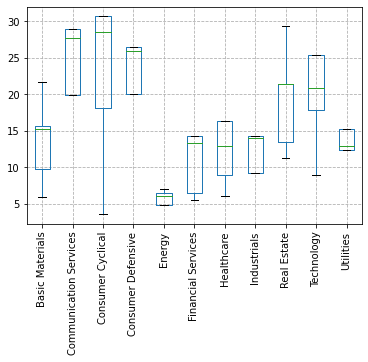

In [149]:
pe_by_sector.T.boxplot(showfliers=False) # showfliers = False permet de ne pas inclure les outliers dans le graphique.
plt.grid(linestyle="--")
plt.xticks(rotation='vertical'); # Ici j'ajoute le ';' pour éviter les logs d'information.

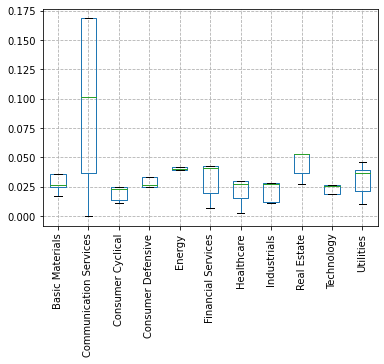

In [150]:
ratio_by_sector = complete2[(complete2["year"] == 2022) & (complete2["quarter"] == 3)].groupby("Sector").agg({
    'div_yield':['min','mean','median','max','std']})

ratio_by_sector.T.boxplot(showfliers=False)
plt.grid(linestyle="--")
plt.xticks(rotation='vertical');

>Plusieurs graphiques font état de valeurs abérrantes. Elles peuvent facilement être mise en lumière et retraitées.

Dans l'exemple ci-dessous, nous allons générer un tableau des statistiques sur les ratios des entreprises du S&P 100 au Q3 2022, mais évitant les valeurs abérrantes.

In [69]:
# Pour le Q3 2022
complete2[(complete2["year"] == 2022) & (complete2["quarter"] == 3)].groupby("Sector")[my_ratios].quantile([0.25, 0.5, 0.75])

pe_ratio  pb_ratio      fcfy       roe  \
Sector                                                                 
Basic Materials        0.25  12.524458  0.331747  0.047519  0.024282   
                       0.50  15.292744  0.417444  0.055676  0.033831   
                       0.75  18.479138  0.640922  0.119910  0.037311   
Communication Services 0.25   8.203201  0.408336  0.021339  0.014285   
                       0.50  19.835012  0.668282  0.051201  0.048947   
                       0.75  22.647406  1.172721  0.122534  0.055726   
Consumer Cyclical      0.25   9.475373 -2.039293  0.005247 -0.080566   
                       0.50  18.058074  1.193695  0.021247  0.035763   
                       0.75  27.798673  3.993320  0.042340  0.090239   
Consumer Defensive     0.25  16.911978  0.457743  0.031024  0.013125   
                       0.50  19.961783  1.754001  0.053494  0.066380   
                       0.75  22.083735  2.639927  0.083600  0.107186   
Energy                 0.25   5.637529  0.452124  0.186721  0.081508   
                       0.50   6.410396  0.471082  0.194196  0.092239   
                       0.75   6.722812  0.563052  0.204582  0.098941   
Financial Services     0.25   8.822445  0.219960  0.052181  0.019275   
                       0.50  13.308010  0.308954  0.162088  0.031773   
                       0.75  18.910765  0.544835  0.314882  0.065634   
Healthcare             0.25  10.383470  0.734730  0.034265  0.034111   
                       0.50  12.950528  1.146832  0.072300  0.065126   
                       0.75  21.136887  1.441183  0.101663  0.089846   
Industrials            0.25  11.105401  0.603864  0.064516  0.061251   
                       0.50  14.303133  1.099464  0.070515  0.130909   
                       0.75  15.677403  1.797050  0.090393  0.156830   
Real Estate            0.25  17.391211  1.850377  0.041416  0.144854   
                       0.50  21.389544  1.901721  0.063671  0.156036   
                       0.75  25.387876  1.953065  0.085927  0.167217   
Technology             0.25  13.531172  1.159669  0.025536  0.010202   
                       0.50  17.839684  2.014653  0.038922  0.075324   
                       0.75  27.458824  2.708371  0.076096  0.147250   
Utilities              0.25  12.725523  0.365068 -0.034492  0.027492   
                       0.50  12.885856  0.436842 -0.003029  0.034496   
                       0.75  15.434220  0.581127  0.029080  0.042096   

                             gross_margin  capex_per_share  
Sector                                                      
Basic Materials        0.25      0.245627         0.525574  
                       0.50      0.368405         0.707422  
                       0.75      0.383816         1.113961  
Communication Services 0.25      0.478440         0.555547  
                       0.50      0.551332         1.020224  
                       0.75      0.588807         2.772850  
Consumer Cyclical      0.25      0.167781         0.524507  
                       0.50      0.293627         0.721601  
                       0.75      0.415034         1.487490  
Consumer Defensive     0.25      0.262756         0.160943  
                       0.50      0.473802         0.208706  
                       0.75      0.579607         1.101075  
Energy                 0.25      0.304848         1.320821  
                       0.50      0.334084         1.480926  
                       0.75      0.359566         1.724060  
Financial Services     0.25      0.505275         0.000000  
                       0.50      0.801077         0.157303  
                       0.75      0.917516         0.591455  
Healthcare             0.25      0.517229         0.235324  
                       0.50      0.666401         0.366682  
                       0.75      0.764085         0.474787  
Industrials            0.25      0.184719         0.402602  
                       0.50      0.246961    

In [70]:
# Pour tout l'historique
complete2.groupby("Sector").quantile([.25, .5, .75])[my_ratios]

pe_ratio  pb_ratio      fcfy       roe  \
Sector                                                                 
Basic Materials        0.25   5.797778  0.115486  0.024020  0.020915   
                       0.50  12.687535  0.245136  0.057598  0.039228   
                       0.75  16.672017  0.716117  0.200601  0.059260   
Communication Services 0.25   5.905476  0.250590  0.020817  0.019420   
                       0.50  16.468712  0.587552  0.053939  0.036520   
                       0.75  28.711544  1.098242  0.143082  0.055202   
Consumer Cyclical      0.25   6.392000  0.385888 -0.016959  0.020142   
                       0.50  13.997134  0.870003  0.031321  0.047479   
                       0.75  22.916536  2.286358  0.077725  0.073048   
Consumer Defensive     0.25  10.585073  0.464291  0.018070  0.035643   
                       0.50  14.212059  0.836106  0.059287  0.062588   
                       0.75  18.909178  1.474878  0.113487  0.103825   
Energy                 0.25   4.798977  0.221105  0.012003  0.023720   
                       0.50   6.866865  0.292213  0.081392  0.042522   
                       0.75  11.585569  0.373711  0.154890  0.057456   
Financial Services     0.25   7.093143  0.181769 -0.013275  0.020968   
                       0.50   9.783485  0.293466  0.089937  0.032909   
                       0.75  13.861744  0.462013  0.329658  0.049031   
Healthcare             0.25   9.109473  0.459937  0.033547  0.029314   
                       0.50  13.037736  0.686101  0.066907  0.049078   
                       0.75  18.184701  1.096486  0.109574  0.077762   
Industrials            0.25  10.011515  0.408481  0.020960  0.037935   
                       0.50  12.759026  0.611342  0.069365  0.054030   
                       0.75  16.865250  0.961485  0.120804  0.077162   
Real Estate            0.25   9.271571  0.299645  0.028113  0.014874   
                       0.50  21.965655  1.012794  0.047801  0.035080   
                       0.75  38.975290  1.856209  0.080181  0.078112   
Technology             0.25  10.141710  0.687170  0.030553  0.037238   
                       0.50  14.208182  1.118789  0.060557  0.061621   
                       0.75  23.478417  1.993229  0.096384  0.093290   
Utilities              0.25   3.255099  0.169534 -0.049430  0.016639   
                       0.50   5.685564  0.237718  0.037208  0.026698   
                       0.75  10.658240  0.335668  0.207697  0.039155   

                             gross_margin  capex_per_share  
Sector                                                      
Basic Materials        0.25      0.173329         0.659406  
                       0.50      0.358457         1.138292  
                       0.75      0.422231         1.566134  
Communication Services 0.25      0.403460         0.156241  
                       0.50      0.568527         0.474578  
                       0.75      0.628646         1.040726  
Consumer Cyclical      0.25      0.210369         0.072093  
                       0.50      0.298686         0.262985  
                       0.75      0.402754         0.520174  
Consumer Defensive     0.25      0.266547         0.119328  
                       0.50      0.479522         0.207888  
                       0.75      0.574512         0.445592  
Energy                 0.25      0.232714         0.627105  
                       0.50      0.305815         1.000460  
                       0.75      0.382551         1.749602  
Financial Services     0.25      0.000000         0.000000  
                       0.50      0.791341         0.091906  
                       0.75      1.000000         0.309942  
Healthcare             0.25      0.422630         0.069203  
                       0.50      0.693365         0.139437  
                       0.75      0.787591         0.250047  
Industrials            0.25      0.184440         0.274314  
                       0.50      0.304300    

> **Attention :** dans le graphique ci-dessous, on trace une boxplot sur une distribution incomplète, car elle n'inclue pas les valeurs du premier quartile ni celles du dernier. Cela permet de normaliser les données autour de la médiane.

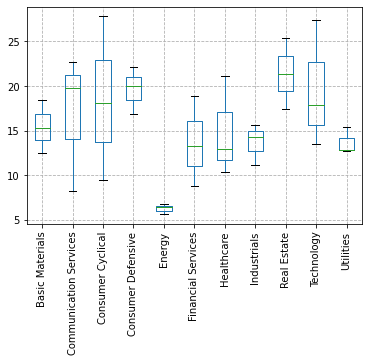

In [161]:
ratio_by_sector = complete2[(complete2["year"] == 2022) & (complete2["quarter"] == 3)].groupby("Sector").quantile([0.25, 0.5, 0.75])

ratio_by_sector["pe_ratio"].unstack().T.boxplot()
plt.grid(linestyle="--")
plt.xticks(rotation='vertical');

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
Ces graphiques sont extrêmement intéressants, en un coup d'oeil, ils nous permettent de voir :<br>
- Les secteurs fortement valorisés et ceux qui le sont moins;<br>
- Les secteurs à forte intensité capitalistique;<br>
- Les secteurs les plus profitables;<br>
- Les secteurs les plus volatiles en termes de ratios financiers;<br>
- etc
</p>

A titre d'exemple, on observe qu'au Q3 2022 :
- le secteur des technology a des ratios de valorisations en moyenne supérieurs aux autres secteurs (pb_ratio, ev_ebitda), mais c'est moins vrai si l'on regarde le price earning_ratio. Si bien que malgré la forte baisse des valeurs technologiques en 2022, il est légitime de se demander si les valorisations ne restent pas encore trop élevées au regard des autres secteurs ?
- Les secteurs pour lesquels les debt_to_equity sont les plus élevées sont naturellement le Real Estate et les Utilities. Ce sont des secteurs qui ne peuvent pas fonctionner sans une dette importante.
- Les secteurs affichant les plus grosses marges brutes sont naturellement les secteurs financiers, la santé, la techno ou encore l'immobilier.
- Si on regarde les capex per share, on retrouve les utilities, les industrials et le secteur de l'énergie.
- Les secteurs qui offrent les meilleurs dividendes sont : Real Estate, Utilities, Financials.

### 2. Vision Temporelle 

In [71]:
complete2.index = complete2["Date"].values

resample1 = complete2.resample("Q").mean()

>La méthode resample() est très utile dans le cas présent, car elle permet de regrouper toutes les dates d'un trimestre, à la dernière date de celui-ci. Comme nous l'avions vu plus haut, certaines entreprises clôturent leur exercice en décalage des autres. Avec cette méthode, nous pouvons regrouper toutes les publications à une fréquence donnée.

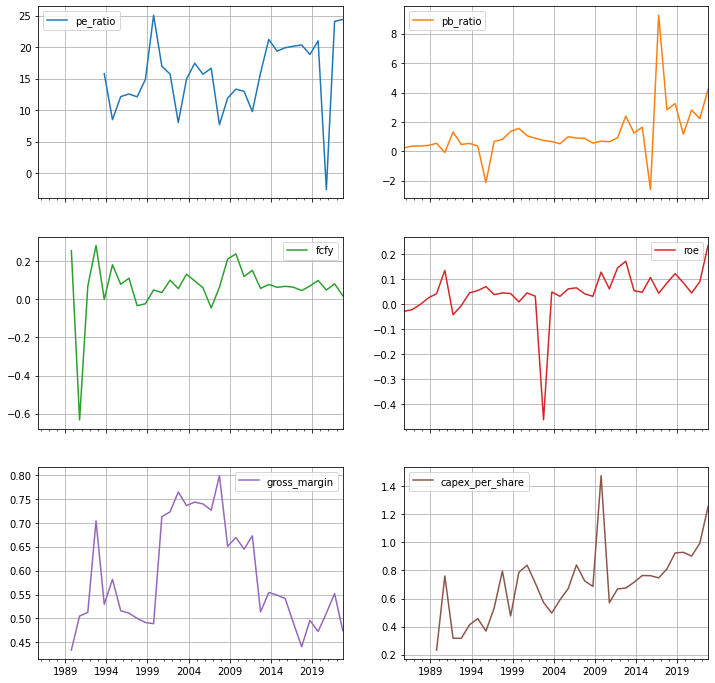

In [72]:
#resample1[resample1["month"] == 12][my_ratios].plot(subplots=True, layout=(3, 2), figsize=(12, 12), grid=True);
resample1[resample1.index.month == 12][my_ratios].plot(subplots=True, layout=(3, 2), figsize=(12, 12), grid=True);

Les graphiques ci-dessus nous permettent de voir l'évolution historique des ratios que l'on étudie. Il faut bien garder en tête les lacunes de notre analyse, nous regardons l'évolution passée des ratios des composantes actuelles d'un indice. Cela veut dire que nous avons dans nos données de nombreux biais, dont ***le biais du survivant***. Il n'est donc pas étonnant de voir certaines métriques avec une moyenne en hausse à travers le temps.

<p style="background-color: #ededed; padding-left: 20px; padding-right: 20px; padding-top: 15px; padding-bottom: 15px; border-radius: 5px; color:black">    
<b>Le Biais du Survivant :</b><br><br> 
Le biais du survivant consiste à tirer des conclusions en ne prêtant attention qu’aux seuls témoignages des individus qui ont réussi (mais qui sont en fait des exceptions statistiques), et en ignorant ceux des autres (qui sont pourtant les plus représentatifs).<br><br>
Comment se concrétise-t-il ?<br>
Beaucoup d'indices boursiers sont "Capitalization-Weighted" (le S&P 500, le Nasdaq, le Cac et plein d'autres), c'est à dire pondérés par la capitalisations boursières. Se faisant, lorsqu'une société fait progresser ses economics et qu'elle grossit, elle a tendance à voir son prix de bourse progresser ainsi que sa capitalisation boursière par la même occasion. Ce genre de société va progresser à travers les indices, des "small cap" vers le "large cap", tandis que celles qui fonctionnent moins bien, voir décroissent dans le temps, elles vont descendre dans les indices. Parce qu'elles sont plus grosses, les "large cap" sont aussi plus à même de survivre aux événnements de marchés, c'est pourquoi les taux de mortalité dans ces indices sont plus faibles (dans certains cas même, le phénomène de "top big to fail" a pu aider des entreprises à rester en vie) et c'est pourquoi c'est un univers où les economics auront tendance à progresser.<br>
<br>
A l'opposer, les entreprises qui vont sortir des grands indices sont celles qui ont vu leurs cours de bourses s'effondrer et donc leur capitalisation boursière également. Leur cours de bourse a pu baisser pour de nombreuses raisons, mais globalement ont peut facilement imaginer que c'est corrélé à des baisses d'economics.<br><br>
<b><em>Finalement, si ces entreprises étaient restées dans les indices de "blue chip", elles auraient eu un impact négatif sur les ratios qu'on a montré plus haut !</em></b>
    
</p>

In [73]:
resample2 = complete2.groupby("Sector").resample("Q").median()

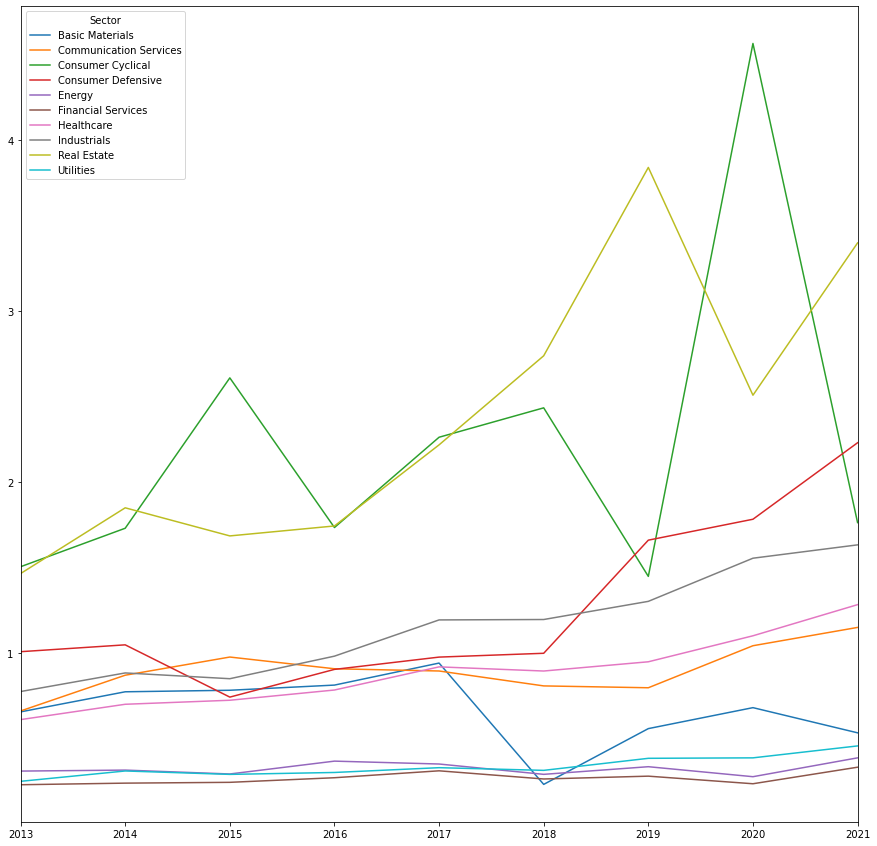

In [76]:
resample2[(resample2["month"] == 12) & (resample2["year"] > 2012)]["pb_ratio"].unstack().T.plot(figsize=(15, 15));

Pour la suite de la l'analyse, nous allons nous placer dans la peau d'un gérant de fonds actions américaine. Sur la base des données que nous avons, nous allons essayer de sélectionner des entreprises sur la base de critères relatifs.

**Critères relatifs :**
- pe_ratio : the smaller the better. Nous voulons des sociétés qui ont du potentiel d'appréciation donc un price earning ratio en dessous de la moyenne de son secteur.
- roe : the higher the better. Nous voulons une entreprise qui n'a pas besoin de dette pour être rentable.
- gross_margin : the higher the better. Nous voulons des sociétés qui produisent avec des marges importantes. Ces marges peuvent êtres distribuées in-fine aux actionnaires, ou réinvesties pour garder un hedge face aux concurrents.  

Nous voulons un portefeuille diversifié, c'est pourquoi nous allons prendre au moins 2 actions de chaque secteur.

Dans un premier temps, nous allons effectuer ce travail sur les données du Q4 2020 !

In [78]:
# Je construis un nouveau dataframe
q4_2020 = complete2[(complete2["year"] == 2020) & (complete2["quarter"] == 4)]

In [79]:
# Je m'assure d'avoir 100 entreprises
len(q4_2020.Ticker.unique())

100

In [164]:
stock_picking = dict()

for cur_sector in q4_2020.Sector.unique():
    tmp = q4_2020[q4_2020.Sector == cur_sector].query("pe_ratio <= pe_ratio.mean()"\
                                            " and roe >= roe.mean()"\
                                            " and gross_margin > gross_margin.mean()").Ticker.values[0:3]
    if len(tmp) > 0:
        stock_picking.update({cur_sector:list(tmp)})

stock_picking

{'Technology': ['AAPL.US', 'QCOM.US'],
 'Industrials': ['FDX.US', 'BA.US', 'GD.US'],
 'Communication Services': ['CHTR.US'],
 'Basic Materials': ['DOW.US'],
 'Financial Services': ['AXP.US'],
 'Utilities': ['EXC.US']}

>Sur ce trimestre, et sur les critères que nous avons définit, seuls 6 secteurs sont représentés avec 9 entreprises sélectionnées.

Dans les interventions qui suivront, nous verrons comment construire un portefeuille avec ses valeurs.

---

<a id='annexe'><h2 style="text-align: center;">ANNEXES</h2></a>

**Accès aux données**

|Interfaces |Commentaires|
|:---|:---|
|Pickling|Protocoles binaires de sérialisation et dé-sérialisation d'objets Python. Il permet de convertir des hiérarchies Python en flux d'octets|
|Flat file (e.g csv)|Fichier plats, par exemple csv ou txt|
|Clipboard|Données mise en mémoire dans le presse-papier|
|Excel|Pas besoin de commentaire :-)|
|JSON|JSON (JavaScript Objet Notation) est un langage léger d’échange de données textuelles|
|HTML|HTML (HyperText Markup Langage), désigne un type de langage informatique descriptif. Il s'agit plus précisément d'un format de données utilisé dans l'univers d'Internet pour insérer et mettre en forme des données dans des pages web|
|XML|XML (Extensible Markup Langage) est un langage de structuration de données, utilisé notamment pour la gestion et l'échange d'informations sur Internet|
|Latex|Langage et un système de composition de documents|
|HDF5|HDF (Hierarchical Data Formats) est un format de fichier qui supporte de grandes quantités de données (big data), complexes et hétérogènes. Il permet également d'intégrer dans les données des meta data|
|Feather|Les fichiers Feather permettent de stocker des data frames et des tables arrow|
|Parquet|Format de stockage en colonne destiné à être utilisé dans des systèmes d'analyse de données|
|ORC|ORC (Optimized Row Columnar) est un format de stockage open source similaire à Parquet. Il permet une intégration facile dans au système Hadoop (framework destiné à faciliter la création d'applications distribuées que ce soit au niveau du stockage des données et de leur traitement)|
|SAS|Permet de lire et d'exploiter des fichiers de données issus de SAS (Statistical Analysis System) que vous avez sûrement dû utiliser en économétrie|
|SPSS|Permet de lire et d'exploiter des fichiers de données issus de SPSS (Statistical Package for the Social Sciences) que vous avez sûrement dû utiliser en économétrie|
|SQL|SQL (Structured Query Language) est un langage informatique utilisé pour exploiter des bases de données|
|Google BigQuery|BigQuery permet l'analyse interactive massive de grands ensembles de données en collaboration avec l'espace de stockage Google|
|STATA|Permet de lire et d'exploiter des fichiers de données issus de STATA qui est un logiciel d'économétrie|

**Ratios financiers**

>***Price-to-earning***
>
>pe_ratio = Market Price / Earnings per Share

>***Price-to-Book***
>
> book_value = Total Assets – Total Liabilities
>
> pb_ratio = Market Price / (book_value / Outstanding Shares)

>***EV/EBITDA***
>
> enterprise_value = Market Capitaliztion + (LongTermDebt + ShortTermDebt) – CashAndEquivalents
>
> ev_ebitda = enterprise_value / Ebitda

>***Free-Cash-Flow Yield***
>
> fcfy = freeCashFlow / (Price * Outstanding Shares)


>***Dividend Yield***
>
>div_yield = (dividendsPaid / Outstanding Shares) / Market Price

>***Return On Equity***
>
>roe = netIncome / totalStockholderEquity

>***Return On Assets***
>
>roa = netIncome / totalAssets

>***Gross Margin***
>
>gross_margin = grossProfit / totalRevenue

>***Debt-to-Equity***
>
>debt_to_equity = (longTermDebt + shortTermDebt) / totalStockholderEquity

>***Capex per Share***
>
>capex_per_shre = capitalExpenditures / Outstanding Shares